<a href="https://colab.research.google.com/github/mahyaalizadeh1995/Knowledge-Distillation/blob/main/knowledge_distillation_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['PYTHONHASHSEED'] = str(42)

import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# define train/test splits
spilts = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# download dataset
(train_data, validation_data, test_data) , info = tfds.load('cats_vs_dogs', with_info=True, as_supervised =True, split=spilts)

num_data = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print(f"There are {num_data} images for {num_classes} classes.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HBRPOI_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
There are 23262 images for 2 classes.


In [ ]:
pixels = 224
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

def format_img(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

# create batches of data
train_batches = train_data.shuffle(num_data // 64).map(format_img).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_data.map(format_img).batch(BATCH_SIZE).prefetch(1)
test_batches = test_data.map(format_img).batch(1)

In [ ]:
class Distiller(keras.Model):

  def __init__(self, student, teacher):
    super(Distiller, self).__init__()
    self.teacher = teacher
    self.student = student


  def compile(self, optimizer, metrics, student_loss_fn,
              distillation_loss_fn, alpha, temperature):

    super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)

    self.student_loss_fn = student_loss_fn
    self.distillation_loss_fn = distillation_loss_fn
    self.alpha = alpha
    self.temperature = temperature

  def train_step(self, data):
    x, y = data

    teacher_predictions = self.teacher(x, training= False)

    with tf.GradientTape() as tape:
      student_predictions = self.student(x, training=True)
      student_loss = self.student_loss_fn(y, student_predictions)

      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1)
      )

      loss = self.alpha * student_loss + (1-self.alpha) * distillation_loss

    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # this done only for the student
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    self.compiled_metrics.update_state(y, student_predictions)

    results = {m.name: m.result() for m in self.metrics}
    results.update({'student_loss':  student_loss, 'distillation_loss': distillation_loss})
    return results

  def test_step(self, data):
    x, y = data

    y_prediction = self.student(x, training=False)

    student_loss = self.student_loss_fn(y, y_prediction)

    self.compiled_metrics.update_state(y, y_prediction)

    results = {m.name: m.result() for m in self.metrics}
    results.update({'student_loss': student_loss})
    return results

  # def call(self, x):
  #   return self.student(x)

In [ ]:
#Teacher model
def create_big_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
      keras.layers.Conv2D(32,(3,3), activation= 'relu', input_shape = (224,224,3)),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(64,(3,3),activation = 'relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Dropout(0.2),
      keras.layers.Conv2D(64, (3,3), activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Conv2D(128,(3,3),activation='relu'),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Dropout(0.5),
      keras.layers.Flatten(),
      keras.layers.Dense(512, activation='relu'),
      keras.layers.Dense(2)
  ])

  return model


#student model
def create_small_model():
  tf.random.set_seed(42)
  model = keras.models.Sequential([
      keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(224,224,3)),
      keras.layers.MaxPooling2D((2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(2)
  ])

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


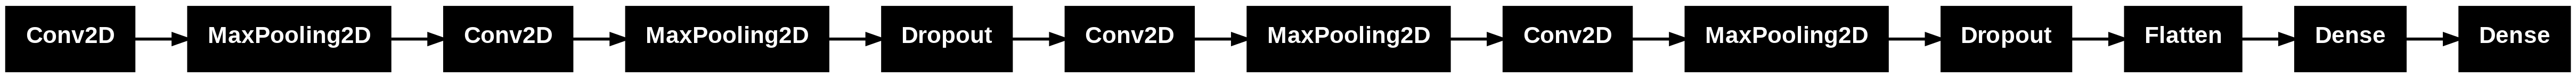

In [ ]:
teacher = create_big_model()
keras.utils.plot_model(teacher, rankdir='LR')

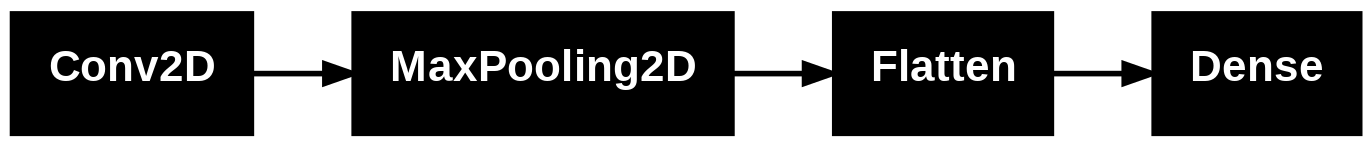

In [ ]:
student = create_small_model()
keras.utils.plot_model(student, rankdir='LR')

In [ ]:
# Calculate the number of trainable parameters
def num_trainable_params(model):
  return np.sum([np.prod(v.shape) for v in model.trainable_weights])

student_params = num_trainable_params(student)
teacher_params = num_trainable_params(teacher)

print(f'teacher model has: {teacher_params} trainable parameters.\n')
print(f'student model has: {student_params} trainable parameters.\n')
print(f'teacher model is {teacher_params//student_params} times bigger than the student model.')

teacher model has: 9568898 trainable parameters.

student model has: 789442 trainable parameters.

teacher model is 12 times bigger than the student model.


In [ ]:
#Train teacher model
teacher.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(),
    metrics =[tf.keras.metrics.SparseCategoricalAccuracy()]
)

teacher_history = teacher.fit(train_batches, epochs=8, validation_data=validation_batches)

Epoch 1/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 65s 95ms/step - loss: 0.7403 - sparse_categorical_accuracy: 0.5212 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.5709
Epoch 2/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - loss: 0.6622 - sparse_categorical_accuracy: 0.6004 - val_loss: 0.5966 - val_sparse_categorical_accuracy: 0.6840
Epoch 3/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - loss: 0.5769 - sparse_categorical_accuracy: 0.7004 - val_loss: 0.4774 - val_sparse_categorical_accuracy: 0.7807
Epoch 4/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.4263 - val_sparse_categorical_accuracy: 0.8100
Epoch 5/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - loss: 0.3974 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8147
Epoch 6/8
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - loss: 0.3479 - sparse_categorical_accuracy: 0.8467 - val_loss: 0.4001 - val_sparse_categorical_accuracy: 0.832

In [ ]:
#Train a student from scratch
student_train = create_small_model()

student_train.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer= keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

student_history = student_train.fit(train_batches, epochs=5, validation_data = validation_batches)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - loss: 1.4077 - sparse_categorical_accuracy: 0.6005 - val_loss: 0.5946 - val_sparse_categorical_accuracy: 0.7111
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 77s 65ms/step - loss: 0.5033 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.6222 - val_sparse_categorical_accuracy: 0.6917
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - loss: 0.3700 - sparse_categorical_accuracy: 0.8380 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.6823
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - loss: 0.2606 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.7737 - val_sparse_categorical_accuracy: 0.6866
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.8975 - val_sparse_categorical_accuracy: 0.6909


In [ ]:
distiller = Distiller(student=student, teacher= teacher)

distiller.compile(
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.05,
    temperature=5,
)

distiller_history= distiller.fit(train_batches, epochs=5, validation_data= validation_batches)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 73ms/step - sparse_categorical_accuracy: 0.6116 - distillation_loss: 0.1176 - loss: -0.0244 - student_loss: 0.7712 - val_sparse_categorical_accuracy: 0.6565 - val_loss: -0.0133 - val_student_loss: 1.0587
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - sparse_categorical_accuracy: 0.7373 - distillation_loss: 0.0732 - loss: -0.0161 - student_loss: 0.5503 - val_sparse_categorical_accuracy: 0.7163 - val_loss: -0.0091 - val_student_loss: 0.7896
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - sparse_categorical_accuracy: 0.7972 - distillation_loss: 0.0556 - loss: -0.0150 - student_loss: 0.4322 - val_sparse_categorical_accuracy: 0.6866 - val_loss: -0.0152 - val_student_loss: 0.9825
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - sparse_categorical_accuracy: 0.8419 - distillation_loss: 0.0440 - loss: -0.0150 - student_loss: 0.3433 - val_sparse_categorical_accuracy: 0.6737 - val_loss: -0.0130 - val_student_loss: 0.9770
Epoch 5/5
582/582 ━━━━

In [ ]:
student_train_acc = student_train.evaluate(test_batches, return_dict=True).get('sparse_categorical_accuracy')
distiller_acc = distiller.evaluate(test_batches, return_dict=True).get('sparse_categorical_accuracy')
teacher_acc = teacher.evaluate(test_batches, return_dict=True).get('sparse_categorical_accuracy')

print(f'\n\n Teacher achieved {teacher_acc*100:.2f}%.\n')
print(f'\n\n distill model achieved {distiller_acc*100:.2f}%.\n')
print(f'\n\n student without distillation achieved {student_train_acc*100:.2f}%.\n')

2326/2326 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.8090 - sparse_categorical_accuracy: 0.7016
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.7276 - loss: -0.0034 - student_loss: 0.8403
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4307 - sparse_categorical_accuracy: 0.8297


 Teacher achieved 84.22%.



 distill model achieved 72.23%.



 student without distillation achieved 69.52%.



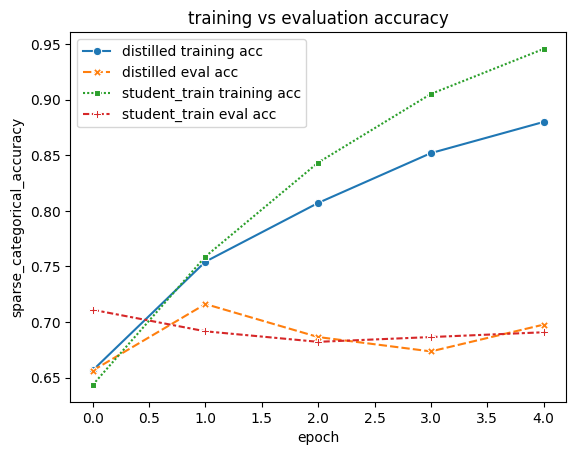

In [ ]:
def get_metrics(history):
  history = history.history
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']
  return acc, val_acc

def plot_train(history_dict):
  metric = {}

  for k, v in history_dict.items():
    acc , val_acc = get_metrics(v)
    metric[f'{k} training acc'] = acc
    metric[f'{k} eval acc'] = val_acc

  plot = pd.DataFrame(metric)

  plot = sns.lineplot(data=plot, markers=True)
  plot.set_title('training vs evaluation accuracy')
  plot.set_xlabel('epoch')
  plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

plot_train({
    'distilled': distiller_history,
    'student_train': student_history,
})